# Cancer Cell Lines Sig Loci Overlaps with TCGA BRCA

In [1]:
import pandas as pd
import numpy as np
import os
from statsmodels.stats.multitest import fdrcorrection
import scipy.stats as stats
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from multiprocessing import cpu_count
import statsmodels
import seaborn as sns
import random
import json as js
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Merge All Cancer Cell Lines Enriched Loci

In [2]:
sig_loci = set()
fisher_loci = pd.read_csv("results/fisher/cell_lines_sig_loci_fisher.bed", sep="\t", header=None)
sig_loci.update(fisher_loci[3])
len(sig_loci)

753

In [3]:
deseq_loci = pd.read_csv("results/DESeq/cell_lines_sig_loci_deseq.bed", sep="\t", header=None)
sig_loci.update(deseq_loci[3])
len(sig_loci)

934

In [4]:
for s in os.scandir("results/DESeq_subtype/"):
    if s.name.endswith(".bed"):
        bed = pd.read_csv(s, sep="\t", header=None)
        print(s.name, bed.shape)
        sig_loci.update(bed[3])
        print(len(sig_loci))

Luminal_sig_loci_deseq.bed (280, 6)
1088
TNBC_sig_loci_deseq.bed (654, 6)
1317
Met_sig_loci_deseq.bed (283, 6)
1353
HER2_sig_loci_deseq.bed (480, 6)
1595


After merging all the various results, we have 1595 unique loci to then overlap with our TCGA data

In [5]:
with open(f"results/all_cell_lines_sig_loci.bed", "wt") as out:   
    for locus in sig_loci:
        splits = locus.split(":")
        start = splits[1].split("-")[0]
        end = splits[1].split("-")[1]
        bed = f"{splits[0]}\t{start}\t{end}\t{locus}\t.\t{splits[-1]}"
        out.write(bed + "\n")  

## All Significant Cell Lines Loci

In [6]:
with open('data/counts/cell_lines_cpm_map.json', 'r') as f:
    cell_lines_cpm_map = js.load(f)
    f.close()
with open('data/counts/cell_lines_exRNA_filtered_loci_counts.json', 'r') as f:
    ex_fil_sample_loci = js.load(f)
    f.close()

In [7]:
#Create df for heatmap visualization
loci_exp = {}
for locus in sig_loci:
    loci_exp[locus] = {}
    for cell_line, loci_dict in ex_fil_sample_loci.items():
        if locus in loci_dict:
            loci_exp[locus][cell_line] = loci_dict[locus] * cell_lines_cpm_map[cell_line] #Transform raw count to cpm. Note we use the cpm_map from non ex-filtered dataset to capture whole count.
        else:
            loci_exp[locus][cell_line] = 0

In [8]:
loci_exp_df = pd.DataFrame.from_dict(loci_exp, orient="index")

In [9]:
subtype_map = {"MDA453":"HER2+", "SKBR-3":"HER2+", 
              "HUMEC":"Normal", "ZR75-1":"Luminal", "HCC38": "TNBC",
              "CN34":"TNBC", "MCF7": "Luminal", "MDA231":"TNBC", 
              "LM2":"Met", "LM1a":"Met"}

In [10]:
colData = pd.DataFrame(loci_exp_df.columns, columns=["Sample"]) #Sample column contains all the samples
colData["Cell Line"] = colData["Sample"].apply(lambda x: x.split("_")[0]) #From sample name, get cell line information
colData["Subtype"] = colData["Cell Line"].apply(lambda x: subtype_map[x]) #Base on cell line, map to subtype category
colData = colData.sort_values("Cell Line").sort_values("Subtype") #First sort by cell line then by subtype
colData = pd.concat([colData[colData["Subtype"] == "Normal"], colData[colData["Subtype"] != "Normal"]]).copy()
colData = colData.set_index("Subtype", drop=False)

colors = sns.color_palette("Paired", len(colData["Subtype"].unique()))
random.shuffle(colors)
lut = dict(zip(list(colData["Subtype"].unique()), colors))
col_colors = colData["Subtype"].map(lut)

In [11]:
#Max norm
loci_df = np.zeros(loci_exp_df.shape)
for i in range(loci_exp_df.shape[0]):
    max_per_row = np.max(loci_exp_df.iloc[i])
    loci_df[i] = np.divide(loci_exp_df.iloc[i], max_per_row) #Max-norm

In [12]:
loci_df = pd.DataFrame(loci_df, index=loci_exp_df.index, columns=loci_exp_df.columns)
loci_df = loci_df[list(colData["Sample"])] #Set columns to match colData order
loci_df.columns = colData["Subtype"]

/rumi/shams/jwang/anaconda3/envs/smRNA/lib/python3.7/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1440x1440 with 0 Axes>

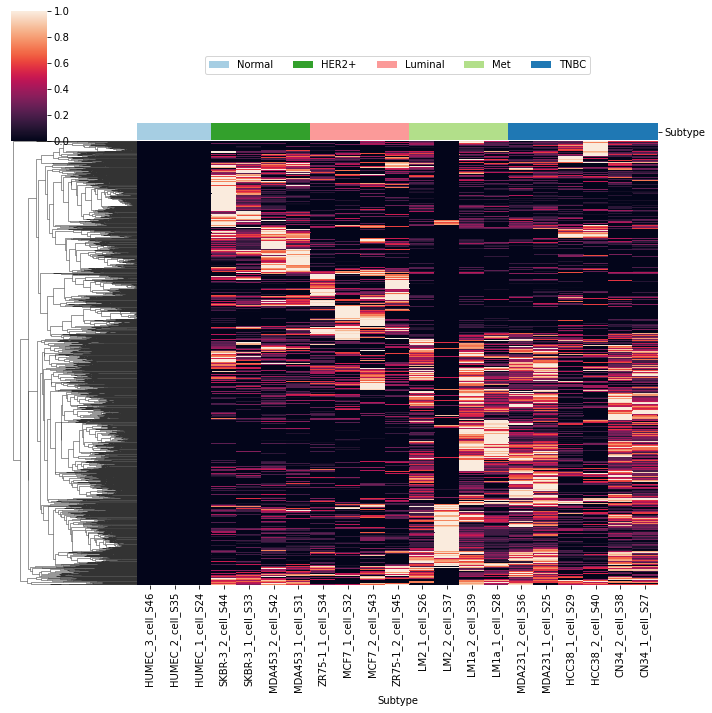

In [13]:
plt.figure(figsize=(20,20))
g=sns.clustermap(loci_df, col_cluster=False, col_colors=col_colors,yticklabels=False, xticklabels=colData["Sample"], method="average")
for label in colData["Subtype"].unique():
    g.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=5)
g.savefig("figures/cell_lines_all_sig_loci_heatmap.pdf")

## Process TCGA Data

In [14]:
tcga_metadata = pd.read_csv("TCGA_metadata.csv")

In [15]:
#Includes all normal samples and breast invasive carcinoma samples from TCGA
tcga_metadata = tcga_metadata[tcga_metadata["Sample"].str.contains("normal") | tcga_metadata["TSS"].str.contains("breast invasive carcinoma")]
print(tcga_metadata.shape)
tcga_metadata = tcga_metadata.set_index("UUID")
tcga_metadata.head()

(1782, 5)


,TCGAbarcode,TSS,Sample,TCGA_abb
UUID,,,,
cc403178-7aa9-47ce-b80b-1019be418539,TCGA-AO-A03L-01A-41R-A057-13,breast invasive carcinoma,primary solid tumor,BRCA
4bfa3f47-d0f3-456a-b50b-2c277a58346c,TCGA-A2-A0CM-01A-31R-A035-13,breast invasive carcinoma,primary solid tumor,BRCA
d3b45613-8747-4459-992b-988de4ba824a,TCGA-E9-A1RB-11A-33R-A156-13,breast invasive carcinoma,solid tissue normal,BRCA
0bad31bd-3d04-4816-8e78-9ee80bdd2b06,TCGA-56-8623-11A-01H-2402-13,lung squamous cell carcinoma,solid tissue normal,LUSC
b6046325-0290-46a1-842d-f60820c8dbe8,TCGA-E2-A3DX-01A-21R-A214-13,breast invasive carcinoma,primary solid tumor,BRCA


### Intersect TCGA Bed Files with Significant Cell Lines Loci

Command: <br>
`ls /rumi/shams/jwang/BRCA_oncRNA/data/TCGA/*.filter.bed | parallel -j 20 bash scripts/intersect_loci.sh {} &> log/TCGA_intersect.out`


## Create TCGA Counts Dictionary

In [16]:
def processLociInput(f):
    bed_file = pd.read_csv(f, header=None, sep="\t")
    sample = f.split("/")[-1].split(".")[0]
    
    preintersect = f"{sample}.filter.bed"
    preintersect_bed = pd.read_csv(f"data/TCGA/{preintersect}", header=None, sep="\t")
    cpm = 1000000 / preintersect_bed.shape[0]  

    loci_features = bed_file[9] #Locus annotation as a feature, based on previously created feature map in preprocess_data.ipynb
    loci_bp_overlaps = bed_file[12]
    read_ids = bed_file[3] #Query ID from original TCGA bamfile for each read.
    
    #Create read_id map
    read_id_locus_map = {}
    for i in range(len(read_ids)):
        _id = read_ids.iloc[i]
        num_bp_match = loci_bp_overlaps.iloc[i]
        locus = loci_features.iloc[i]
        
        if _id in read_id_locus_map: #Indicates multiple hits/overlaps
            if num_bp_match > read_id_locus_map[_id]["bp"]: #Update locus count if more number of bp matched.
                read_id_locus_map[_id] = {"locus":locus, "bp":num_bp_match}
        else:
            read_id_locus_map[_id] = {"locus":locus, "bp":num_bp_match}
            
    assert len(read_id_locus_map) == len(bed_file[3].unique()) #Ensures we do not overcount reads
    
    sample_loci = {}
    sample_loci[sample] = {}
    sample_loci["cpm"] = cpm
    for _id in read_id_locus_map:
        locus = read_id_locus_map[_id]["locus"]
        if locus in sample_loci[sample]:
            sample_loci[sample][locus] += 1
        else:
            sample_loci[sample][locus] = 1      
            
    return sample_loci      

In [17]:
brca_bed = [f.path for f in os.scandir("data/TCGA/") if f.name.endswith(".loci.bed")]
results = Parallel(n_jobs=20)(delayed(processLociInput)(i) for i in brca_bed)

/rumi/shams/jwang/anaconda3/envs/smRNA/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [18]:
len(results)

1782

https://github.com/scikit-learn/scikit-learn/issues/14626
<br> Seems like a common warning.

In [19]:
brca_sample_loci = {}
brca_cpm_map = {}
for r in results:
    for key, val in r.items(): #Only two keys: cpm and sample name
        if key != "cpm": 
            sample = key
            brca_sample_loci[key] = val
        else:
            cpm = val
            
    brca_cpm_map[sample] = cpm

In [20]:
with open('data/counts/brca_sig_cell_lines_loci.json', 'w') as f:
    js.dump(brca_sample_loci, f)
    f.close()

In [21]:
with open('data/counts/brca_cpm_map.json', 'w') as f:
    js.dump(brca_cpm_map, f)
    f.close()

## Run Normal Filter Threshold and Fisher Test
Here we run the normal filter thresholding along with Fisher Test on the overlapping loci.

In [22]:
brca_samples = set(tcga_metadata[~tcga_metadata["Sample"].str.contains("normal")]["TCGAbarcode"])
normal_samples = set(tcga_metadata[tcga_metadata["Sample"].str.contains("normal")]["TCGAbarcode"])

In [23]:
brca_loci = {}
norm_loci = {}
for sample, locus_dict in brca_sample_loci.items():
    count_loci = brca_loci if sample in brca_samples else norm_loci       
    for locus in locus_dict:
        if locus in count_loci:
            count_loci[locus] += 1
        else:
            count_loci[locus] = 1

In [24]:
brca_thresh = 0.1 #For now we will keep this constant
fdr_overlaps = []
sig_overlaps = []
sig_ratio = []
fdr_ratio = []
for i in range(1, 51):
    fil_brca_loci = {}
    fil_norm_loci = {}
    norm_thresh = i/100
    
    for locus in brca_loci: #We are not interested in RNAs not found in brca_rnas, hence we only consider brca_rnas
        if locus in norm_loci and norm_loci[locus] > 679 * norm_thresh:
            continue
        if locus in brca_loci and brca_loci[locus] < 1103 * brca_thresh: 
            continue
        if locus in brca_loci:
            fil_brca_loci[locus] = brca_loci[locus]
        else:
            fil_brca_loci[locus] = 0 #Not present. This line is not very necessary as all the loci we are looking at are coming from brca_loci, but here for ease of reading

        if locus in norm_loci:
            fil_norm_loci[locus] = norm_loci[locus]
        else:
            fil_norm_loci[locus] = 0 #Not present
        
    #Fisher
    tcga_locus_pval = {}
    for locus in fil_brca_loci:
        test_count = fil_brca_loci[locus]
        ctrl_count = fil_norm_loci[locus]
        oddsratio, pvalue = stats.fisher_exact([[test_count, ctrl_count],[1103-test_count, 679-ctrl_count]], "greater")
        tcga_locus_pval[locus] = pvalue
        
    tcga_locus_pval_df = pd.DataFrame.from_dict(tcga_locus_pval, orient="index", columns=["pval"])
    
    rej, fdr = fdrcorrection(tcga_locus_pval_df["pval"], alpha=0.1)
    tcga_locus_pval_df["fdr"] = fdr  
    fdr_tcga_locus_df = tcga_locus_pval_df[tcga_locus_pval_df["fdr"] <= 0.1]
    sig_tcga_locus_df = tcga_locus_pval_df[tcga_locus_pval_df["pval"] <= 0.05]

    fdr_tcga_bed = []
    for locus in fdr_tcga_locus_df.index:
        ref = locus.split(":")[0]
        strand = locus.split(":")[-1]
        start = locus.split(":")[1].split("-")[0]
        end = locus.split(":")[1].split("-")[1]
        fdr_tcga_bed.append(f"{ref}\t{start}\t{end}\t{locus}\t.\t{strand}")
        
    fdr_overlaps.append(len(fdr_tcga_bed))
    fdr_ratio.append(len(fdr_tcga_bed)/679)
    fdr_tcga_bed = pd.DataFrame(fdr_tcga_bed)
    fdr = f"results/thresholds/{i}%_fdr_tcga.bed"
    fdr_tcga_bed.to_csv(fdr, header=None, index=None)

In [27]:
overlap_results = {"fdr":fdr_overlaps, "fdr_ratio":fdr_ratio, "threshold": [p/100 for p in range(1, 51)]}
overlap_results = pd.DataFrame(overlap_results)

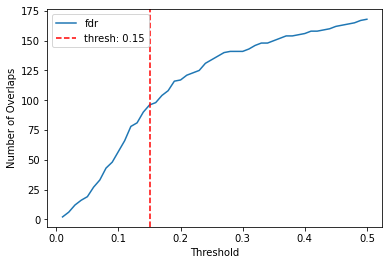

In [28]:
plt.plot('threshold', 'fdr', data=overlap_results)
plt.xlabel("Threshold")
plt.ylabel("Number of Overlaps")
ax = plt.gca()
ax.axvline(0.15, color = "r", ls="--", label="thresh: 0.15")
plt.legend()
plt.savefig("figures/num_overlaps_vs_filter_thresh.pdf")

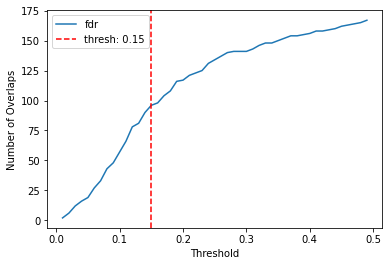

In [41]:
plt.plot('threshold', 'fdr', data=overlap_results)
plt.xlabel("Threshold")
plt.ylabel("Number of Overlaps")
ax = plt.gca()
ax.axvline(0.15, color = "r", ls="--", label="thresh: 0.15")
plt.legend()
plt.savefig("figures/num_overlaps_vs_filter_thresh.pdf")

In [29]:
sig_brca_sig_cl_df = pd.read_csv("results/thresholds/15%_fdr_tcga.bed", header=None, sep="\t")
sig_brca_sig_cl_df.shape

(96, 6)

## Plot Significant Loci in TCGA BRCA

In [30]:
samples = []
samples.extend(normal_samples)
samples.extend(brca_samples)

In [31]:
sig_brca_sig_cl_loci = np.zeros((96, len(samples)))
sig_brca_sig_cl_binary_loci = np.zeros((96, len(samples)))

i = 0
brca_cl_loci_index = []
for locus in sig_brca_sig_cl_df[3]:
    brca_cl_loci_index.append(locus)
    for j in range(len(samples)):
        s = samples[j]
        loci_dict = brca_sample_loci[s]
        if locus in loci_dict:
            sig_brca_sig_cl_loci[i,j] = loci_dict[locus] * brca_cpm_map[s] #cpm norm
            sig_brca_sig_cl_binary_loci[i,j] = 1               
    i += 1

In [32]:
colData = pd.DataFrame(samples, columns=["Barcode"]) #Sample column contains all the samples
colData["Sample"] = colData["Barcode"].apply(lambda x: tcga_metadata[tcga_metadata["TCGAbarcode"] == x]["Sample"].item()) #Base on cell line, map to subtype category
colData["Type"] = colData["Sample"].apply(lambda x: "Normal" if "normal" in x else "Cancer")
colData = pd.concat([colData[colData["Type"] == "Normal"], colData[colData["Type"] != "Normal"]]).copy()
colData = colData.set_index("Type", drop=False)
colors = sns.color_palette("Paired", len(colData["Type"].unique()))
random.shuffle(colors)
lut = dict(zip(list(colData["Type"].unique()), colors))
col_colors = colData["Type"].map(lut)

In [33]:
sig_brca_sig_cl_binary_loci_df = pd.DataFrame(sig_brca_sig_cl_binary_loci , columns=samples, index=brca_cl_loci_index)
binary_df = sig_brca_sig_cl_binary_loci_df[list(colData["Barcode"])].copy() #Sort
binary_df.columns = colData["Type"] #Switch column name to just cell line type

/rumi/shams/jwang/anaconda3/envs/smRNA/lib/python3.7/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


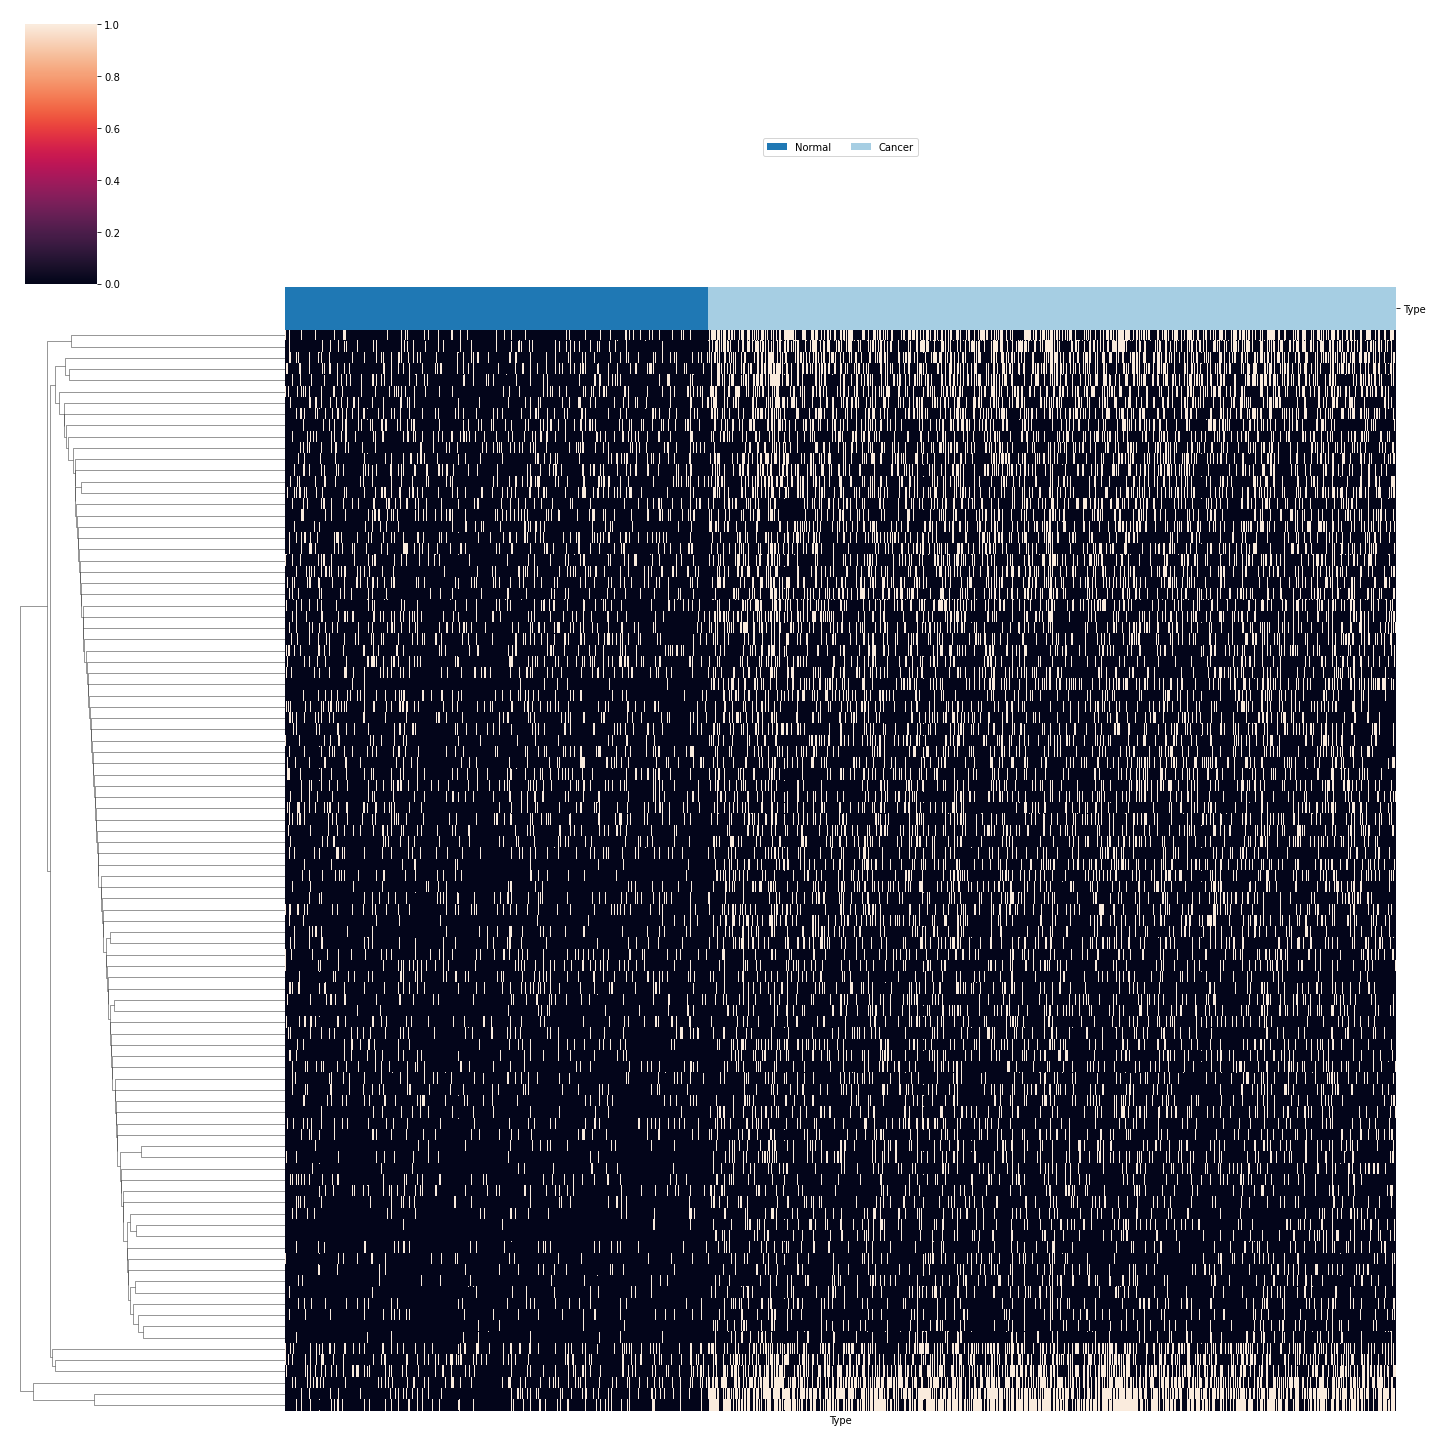

In [34]:
g=sns.clustermap(binary_df,figsize=(20,20), col_cluster=False, col_colors=col_colors, yticklabels=False, xticklabels=False)
for label in colData["Type"].unique():
    g.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)
    
g.ax_col_dendrogram.legend(loc="center", ncol=5)
g.savefig("figures/sig_loci_overlaps_binary_heatmap.pdf")

In [35]:
#First we row normalize the expression for visualization
norm_sig_brca_sig_cl_loci = np.zeros((96, len(samples)))
for i in range(sig_brca_sig_cl_loci.shape[0]):
    max_per_row = np.percentile(sig_brca_sig_cl_loci[i], 99)
    norm_sig_brca_sig_cl_loci[i] = np.divide(sig_brca_sig_cl_loci[i], max_per_row) #Max-norm

In [36]:
norm_sig_brca_sig_cl_loci_df = pd.DataFrame(norm_sig_brca_sig_cl_loci, columns=samples, index=brca_cl_loci_index)
exp_df = norm_sig_brca_sig_cl_loci_df[list(colData["Barcode"])].copy() #Sort
exp_df.columns = colData["Type"] #Switch column name to just cell line type

/rumi/shams/jwang/anaconda3/envs/smRNA/lib/python3.7/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


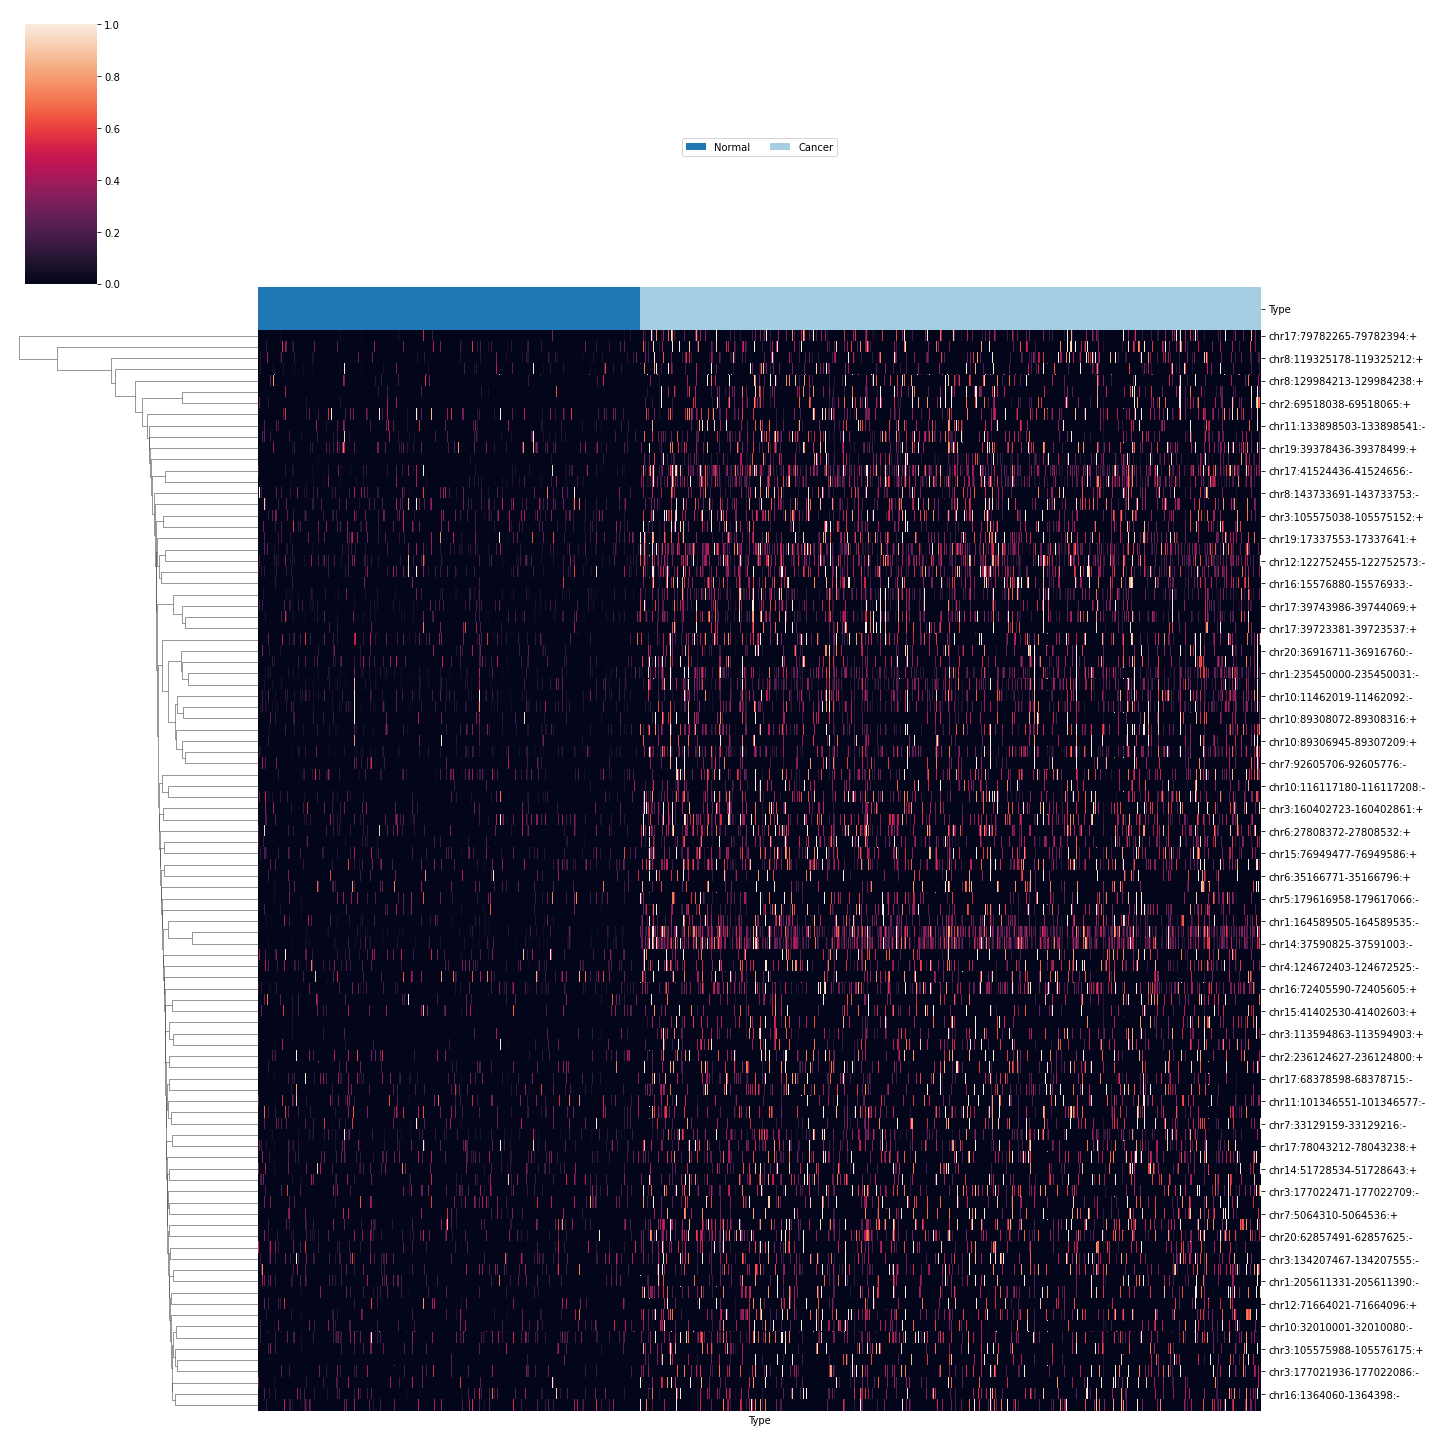

In [37]:
g=sns.clustermap(exp_df,figsize=(20,20), col_cluster=False, col_colors=col_colors, xticklabels=False, vmax=1)
for label in colData["Type"].unique():
    g.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)
    
g.ax_col_dendrogram.legend(loc="center", ncol=5)
g.savefig("figures/sig_loci_overlaps_exp_heatmap.pdf")